In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt


# Models
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults

from mpl_toolkits.axes_grid1 import make_axes_locatable

#####################
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = set(['retina'])
%config InlineBackend.rc = {'figure.figsize': (1.618*4, 4)} # Plots as golden rectangles by default.
matplotlib.rc('font', **{'family': 'serif'})

import seaborn as sns
# Set text.usetex to False if you do not have LaTeX installed
sns.set(context='paper',
        style='whitegrid',
        font='serif',
        font_scale=1.5, 
        rc={'text.usetex': True})
sns.set_palette('deep')




In [4]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Construct absolute paths based on the current working directory
multispecDataPath = os.path.join(current_dir, "Data", "Biomass_data", "rededge", "Train")
lidarDataPath = os.path.join(current_dir, "Data", "Biomass_data", "hovermap", "Train")

# Your code remains the same for dates
dates = ['171108', '171220', '180131', '180315', '180426', '180606']
multispecDataPath


'C:\\Users\\Lenovo\\OneDrive\\Desktop\\BE Project\\Data\\Biomass_data\\rededge\\Train'

<Axes: >

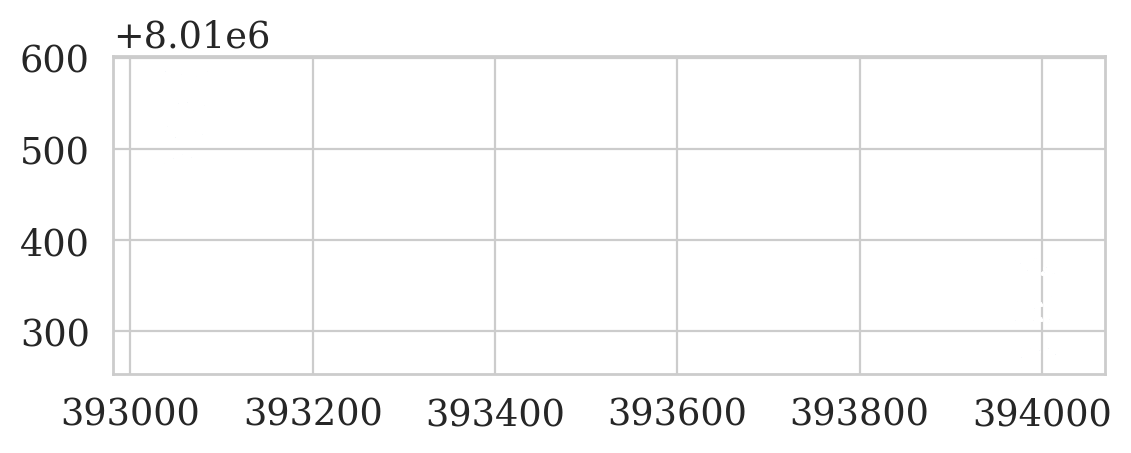

In [5]:
import os
import geopandas as gpd
import pandas as pd


# Since we're loading shape files, use GeoPandas
multispec_raw = gpd.GeoDataFrame()
lidar_raw = gpd.GeoDataFrame()

#Set text.usetex to False
matplotlib.rcParams['text.usetex'] = False


for date in dates: 
    temp1 = gpd.GeoDataFrame().from_file(os.path.join(multispecDataPath, 'WT1_biomass_' + date + '_train.shp'))
    temp2 = gpd.GeoDataFrame().from_file(os.path.join(multispecDataPath, 'WT2_biomass_' + date + '_train.shp'))
    multispec_raw = gpd.GeoDataFrame(pd.concat([multispec_raw, temp1, temp2], axis=0))

    temp1 = gpd.GeoDataFrame().from_file(os.path.join(lidarDataPath, 'WT1_biomass_' + date + '_train.shp'))
    temp2 = gpd.GeoDataFrame().from_file(os.path.join(lidarDataPath, 'WT2_biomass_' + date + '_train.shp'))
    lidar_raw = gpd.GeoDataFrame(pd.concat([lidar_raw, temp1, temp2], axis=0))

# Reset the indices
# We won't set Date to be the index at the moment,
# we'll do that on the merged data set.
multispec_raw = multispec_raw.reset_index()
lidar_raw = lidar_raw.reset_index()
lidar_raw.plot()

In [6]:
multispec_raw = multispec_raw.drop(['geometry', 'index', 'Sample'], axis=1)
lidar_raw = lidar_raw.drop(['geometry', 'index', 'Sample'], axis=1)

In [7]:
auxillary_var_names = ['UNIQUE', 'WT', 'N','Stalks_num', 'Total_B_kg', 'Stem_B_kg', 'Leaf_B_kg', 'Date']
multispec_var_names = sorted(list(set(multispec_raw.columns) - set(auxillary_var_names)))
lidar_var_names = sorted(list(set(lidar_raw.columns) - set(auxillary_var_names)))
multispec_var_names

['avg_EVI',
 'avg_GDVI',
 'avg_GRVI',
 'avg_NDRE',
 'avg_NDVI',
 'avg_SAVI',
 'avg_SCCCI',
 'avg_TCARI',
 'avg_TGI',
 'avg_VARI',
 'max_EVI',
 'max_GDVI',
 'max_GRVI',
 'max_NDRE',
 'max_NDVI',
 'max_SAVI',
 'max_SCCCI',
 'max_TCARI',
 'max_TGI',
 'max_VARI',
 'min_EVI',
 'min_GDVI',
 'min_GRVI',
 'min_NDRE',
 'min_NDVI',
 'min_SAVI',
 'min_SCCCI',
 'min_TCARI',
 'min_TGI',
 'min_VARI',
 'p25_EVI',
 'p25_GDVI',
 'p25_GRVI',
 'p25_NDRE',
 'p25_NDVI',
 'p25_SAVI',
 'p25_SCCCI',
 'p25_TCARI',
 'p25_TGI',
 'p25_VARI',
 'p50_EVI',
 'p50_GDVI',
 'p50_GRVI',
 'p50_NDRE',
 'p50_NDVI',
 'p50_SAVI',
 'p50_SCCCI',
 'p50_TCARI',
 'p50_TGI',
 'p50_VARI',
 'p75_EVI',
 'p75_GDVI',
 'p75_GRVI',
 'p75_NDRE',
 'p75_NDVI',
 'p75_SAVI',
 'p75_SCCCI',
 'p75_TCARI',
 'p75_TGI',
 'p75_VARI',
 'std_EVI',
 'std_GDVI',
 'std_GRVI',
 'std_NDRE',
 'std_NDVI',
 'std_SAVI',
 'std_SCCCI',
 'std_TCARI',
 'std_TGI',
 'std_VARI']

In [8]:
data = pd.merge(multispec_raw, lidar_raw, on=auxillary_var_names)

# Set datetime index
data['Date'] = pd.to_datetime(data['Date'], format="%y%m%d")
data = data.set_index('Date')

# Since we're setting `Date` to be the index, drop it from the auxillary_vars
auxillary_var_names.remove('Date')

# Let's take a gander at our data.
data.head()

,UNIQUE,WT,N,Stalks_num,Total_B_kg,Stem_B_kg,Leaf_B_kg,max_NDVI,avg_NDVI,min_NDVI,...,b70,b75,b80,b85,b90,b95,d00,d01,d02,d03
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,wt1-01,WT1,70.0,35.0,25.3,20.1,4.6,0.773139,0.599807,0.305283,...,0.967,0.978,0.989,0.996,0.998,0.999,0.287,0.601,0.112,0.001
2017-11-08,wt1-02,WT1,70.0,20.0,21.6,17.4,3.7,0.727260,0.547928,0.324244,...,0.982,0.989,0.994,0.995,0.997,0.999,0.352,0.548,0.092,0.009
2017-11-08,wt1-03,WT1,190.0,44.0,32.7,15.4,5.3,0.724652,0.523674,0.297666,...,0.991,0.994,0.997,0.997,0.999,0.999,0.576,0.384,0.039,0.001
2017-11-08,wt1-04,WT1,0.0,28.0,21.1,17.0,3.5,0.775482,0.575587,0.313977,...,0.955,0.972,0.983,0.990,0.996,0.998,0.440,0.409,0.148,0.002
2017-11-08,wt1-05,WT1,0.0,31.0,29.3,24.3,5.0,0.787609,0.578986,0.318247,...,0.952,0.969,0.980,0.987,0.995,0.999,0.080,0.759,0.147,0.015


In [9]:
multispec_data = data[multispec_var_names]
lidar_data = data[lidar_var_names]

print('Multispec: ' + str(multispec_data.shape))
print('LiDAR: ' + str(lidar_data.shape))

Multispec: (336, 70)
LiDAR: (336, 46)


Text(0, 0.5, 'Number of Stems')

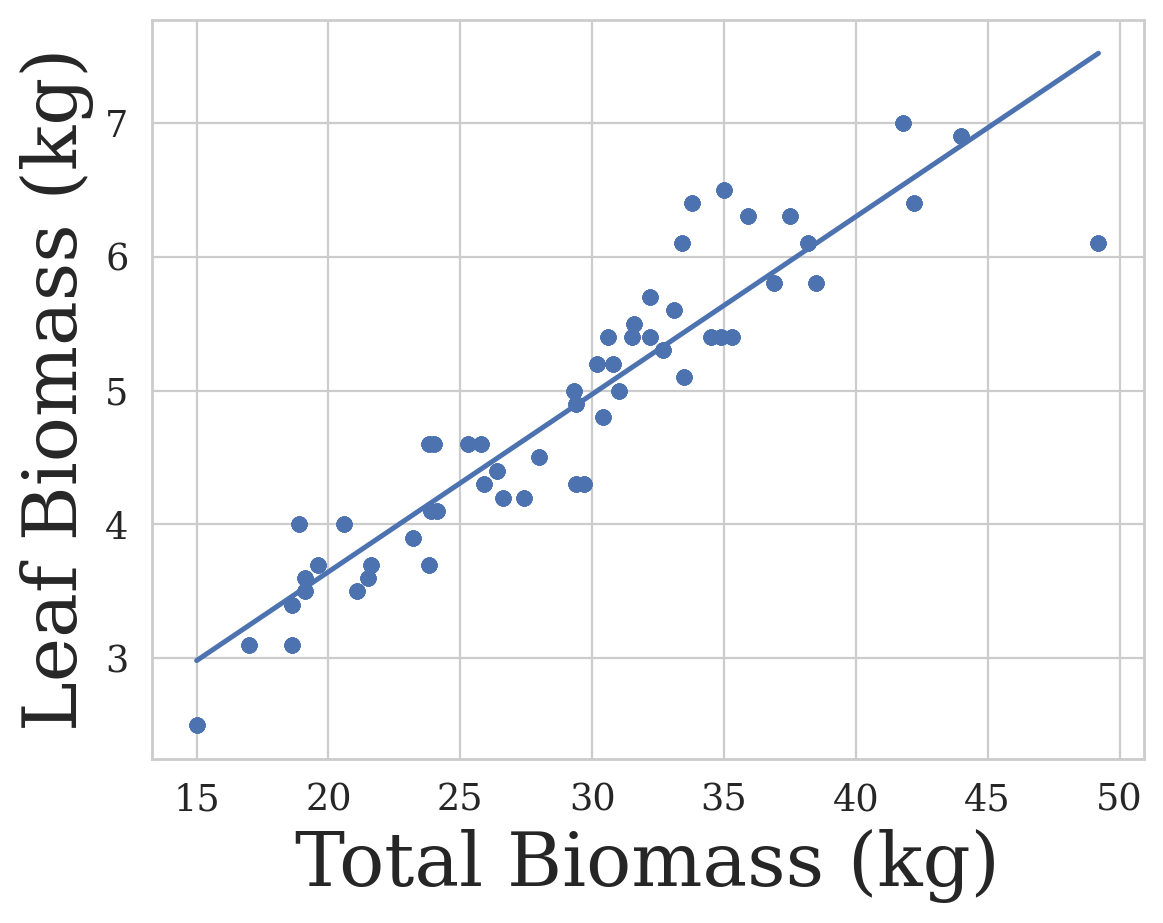

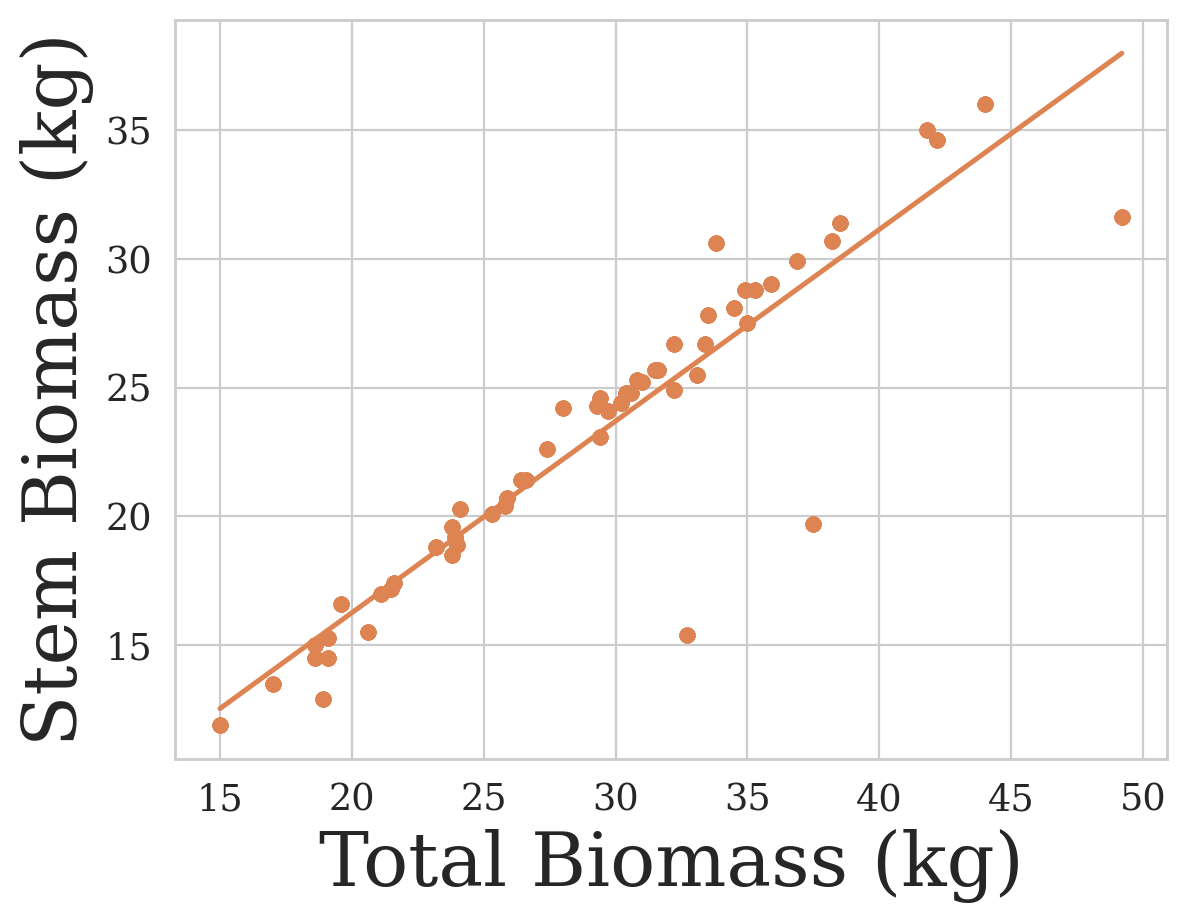

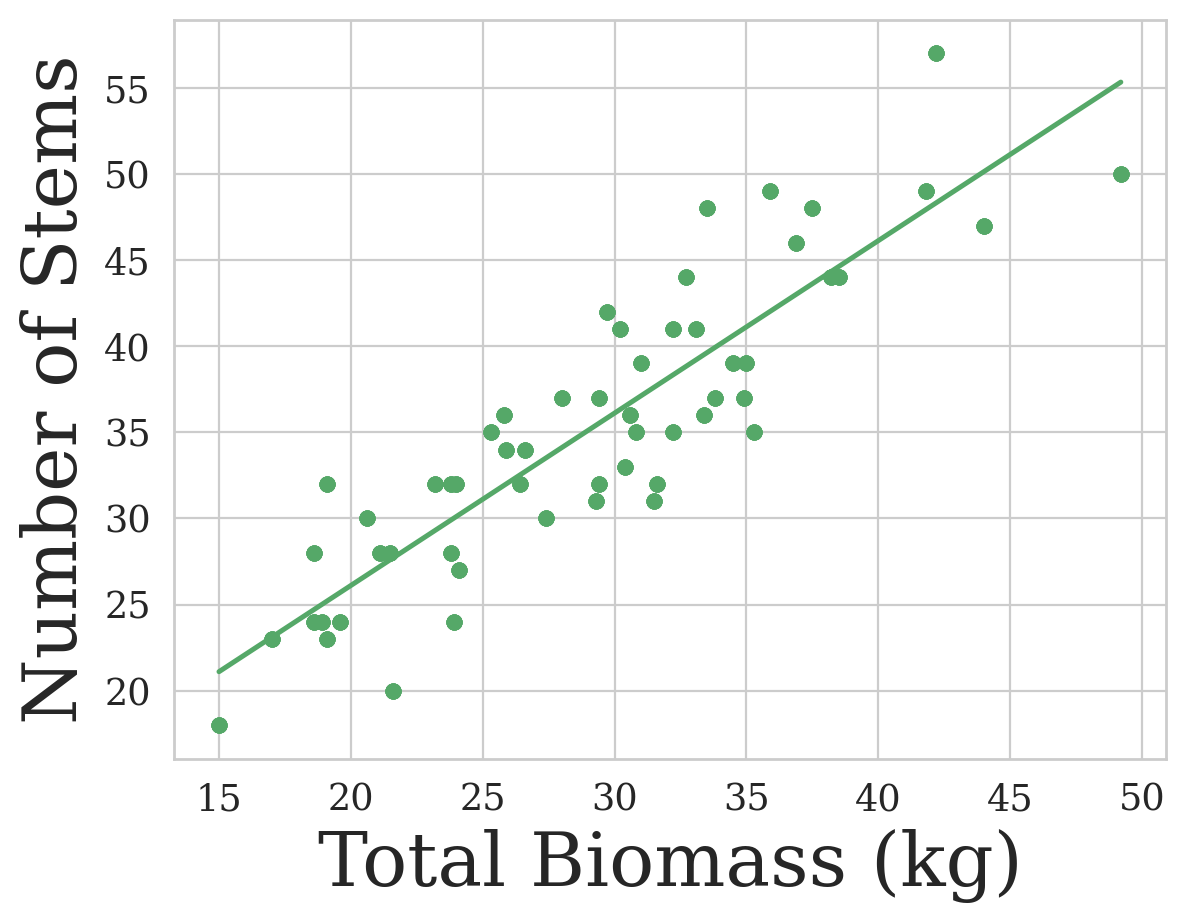

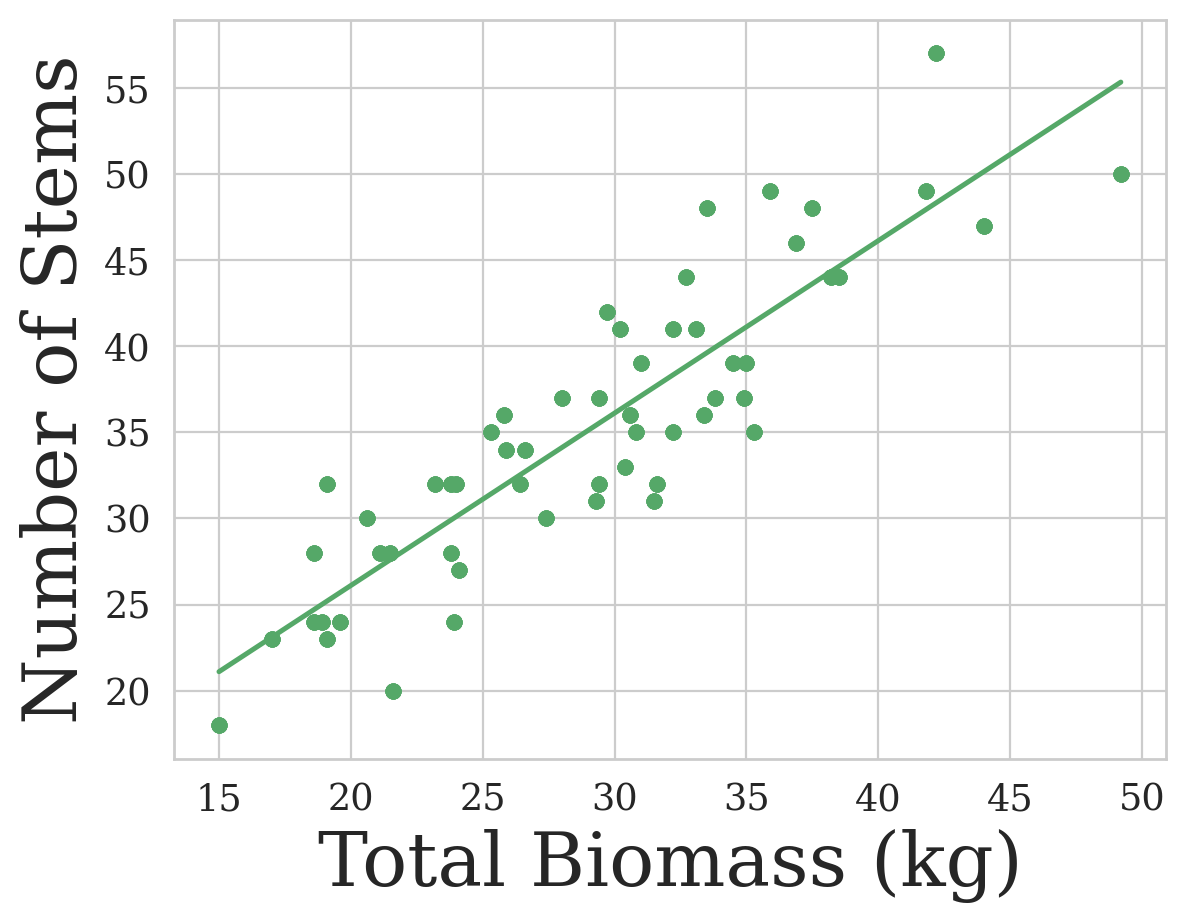

In [10]:
import os

# ...
# Font size for labels and legend
fsize = 27
fsize_legend = 18

# Leaf Biomass
plt.figure()
sns.regplot(x='Total_B_kg', y='Leaf_B_kg', data=data, ci=None)
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Leaf Biomass (kg)', fontsize=fsize)


# Stem
plt.figure()
sns.regplot(x='Total_B_kg', y='Stem_B_kg', data=data, ci=None, color=sns.color_palette()[1])
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Stem Biomass (kg)', fontsize=fsize)


# Number Stems
plt.figure()
sns.regplot(x='Total_B_kg', y='Stalks_num', data=data, ci=None, color=sns.color_palette()[2])
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Number of Stems', fontsize=fsize)

plt.figure()
sns.regplot(x='Total_B_kg', y='Stalks_num', data=data, ci=None, color=sns.color_palette()[2])
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Number of Stems', fontsize=fsize)


In [11]:
X = data['Total_B_kg']
X = sm.add_constant(X)
y = data['Leaf_B_kg']
print('Total vs Leaf. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

y = data['Stem_B_kg']
print('Total vs Stem. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

y = data['Stalks_num']
print('Total vs Number of Stems. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

Total vs Leaf. R2 = 0.86

Total vs Stem. R2 = 0.84

Total vs Number of Stems. R2 = 0.78



In [12]:
multispec_scale =  multispec_data.std()
lidar_scale = lidar_data.std()
lidar_scale


avg    0.922472
b05    0.144354
b10    0.186207
b15    0.210017
b20    0.225447
b25    0.236057
b35    0.249353
b40    0.253983
b45    0.257141
b50    0.258184
b55    0.256572
b60    0.251159
b65    0.239069
b70    0.216436
b75    0.177297
b80    0.121262
b85    0.061905
b90    0.019954
b95    0.003051
d00    0.115668
d01    0.192348
d02    0.060400
d03    0.315369
kur    2.003929
max    1.065257
p05    0.156643
p10    0.548339
p15    0.811426
p20    0.963496
p25    1.047526
p35    1.101393
p40    1.109533
p45    1.112615
p50    1.113543
p55    1.109656
p60    1.103389
p65    1.098449
p70    1.092062
p75    1.083940
p80    1.071788
p85    1.055984
p90    1.039797
p95    1.027504
qav    3.189426
ske    1.163687
std    0.280396
dtype: float64

In [13]:
# Do PCA on multispec and LiDAR independently. 
# Retain 10 components at first to generate the scree plot.
n_components = 10

# Scale data
multispec_data_scaled = multispec_data / multispec_scale
multispec_pca = PCA(n_components=n_components, whiten=True).fit(multispec_data_scaled)
multispec_pca.singular_values_

array([113.84201891,  70.48437996,  51.91235741,  30.96414718,
        22.76116125,  18.30359932,  13.02914734,  12.66179147,
        10.52700486,   9.10538225])

In [14]:
lidar_data_scaled = lidar_data / lidar_scale
lidar_pca = PCA(n_components=n_components, whiten=True).fit(lidar_data_scaled)
lidar_pca.explained_variance_ratio_


array([0.82935772, 0.06790207, 0.03278408, 0.0227794 , 0.01300438,
       0.00939886, 0.00693373, 0.00620463, 0.00385121, 0.00232343])

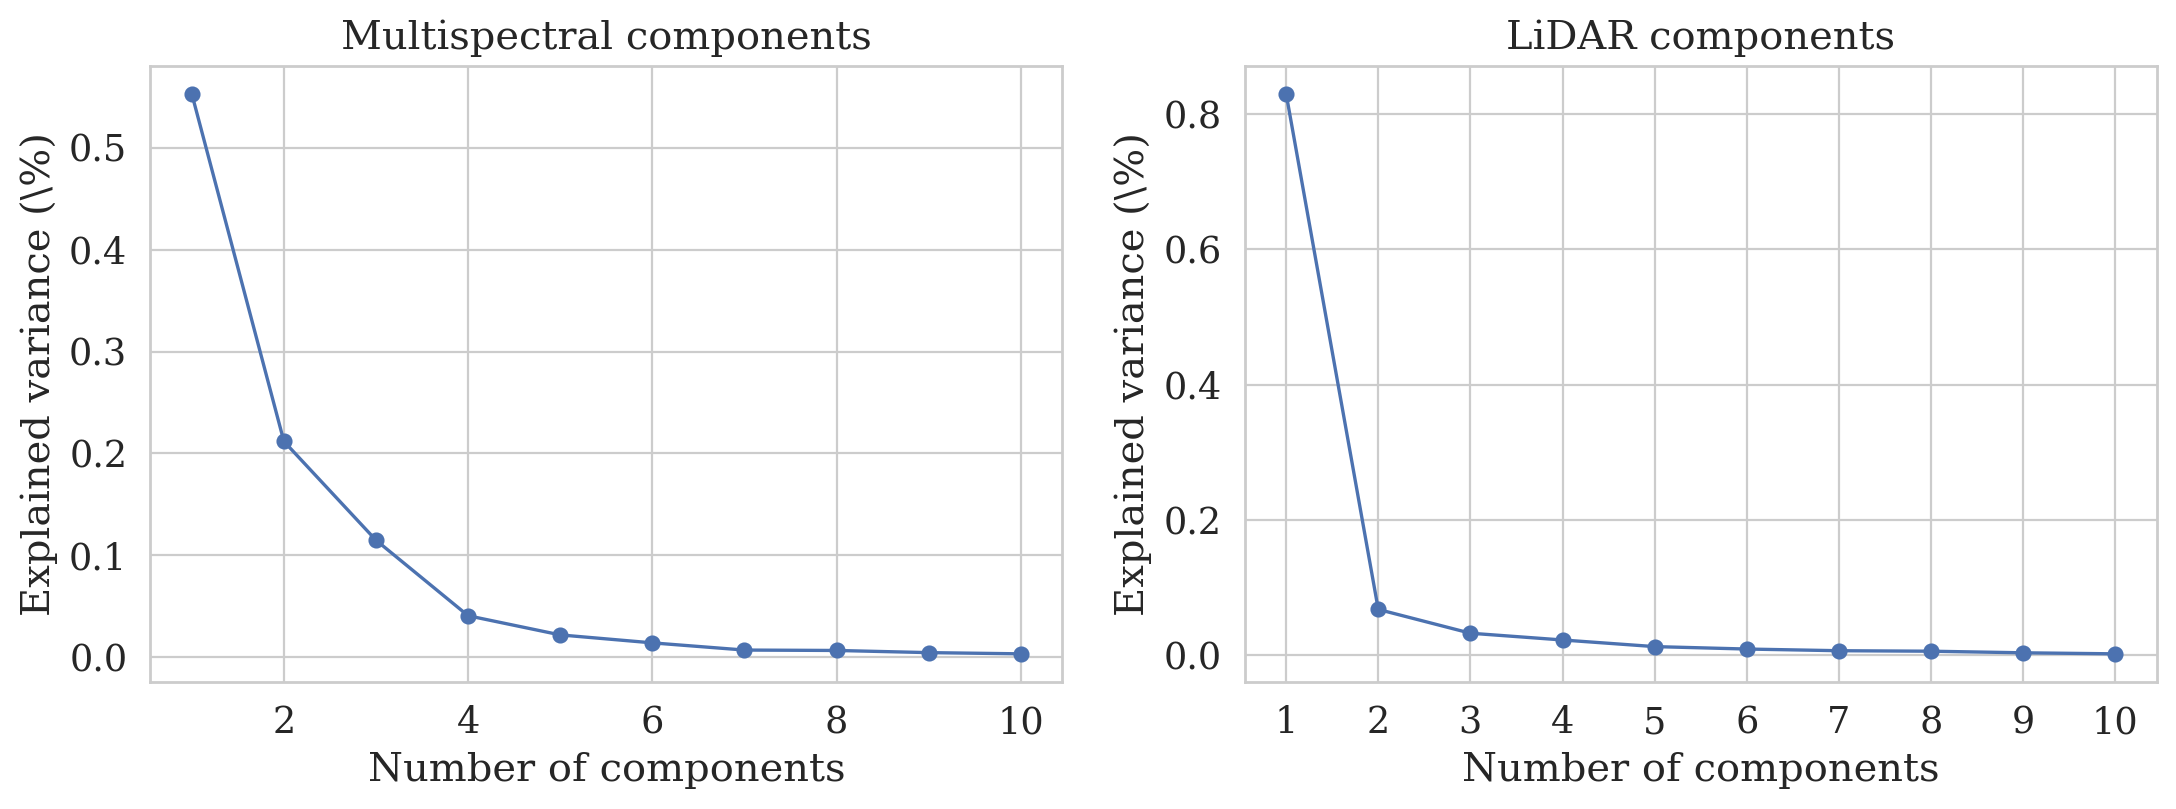

Cumulative explained variance: Multispec
[0.55266547 0.76452252 0.87944332 0.9203294  0.94242195 0.9567086
 0.96394777 0.97078449 0.97551019 0.97904572]

Cumulative explained variance: LiDAR
[0.82935772 0.89725979 0.93004387 0.95282327 0.96582765 0.97522651
 0.98216024 0.98836487 0.99221608 0.99453951]


In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*1.618*4, 4))

ax[0].plot(np.arange(1, n_components + 1), multispec_pca.explained_variance_ratio_, 'o-')
plt.xticks(np.arange(1, n_components + 1))
ax[0].set_title("Multispectral components")
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance (\%)')

ax[1].plot(np.arange(1, n_components + 1), lidar_pca.explained_variance_ratio_, 'o-')
plt.xticks(np.arange(1, n_components + 1))
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Explained variance (\%)')
ax[1].set_title("LiDAR components")
plt.show()

print("Cumulative explained variance: Multispec")
print(np.cumsum(multispec_pca.explained_variance_ratio_))
multispec_cumsum = np.cumsum(multispec_pca.explained_variance_ratio_)

print("\nCumulative explained variance: LiDAR")
print(np.cumsum(lidar_pca.explained_variance_ratio_))
lidar_cumsum = np.cumsum(lidar_pca.explained_variance_ratio_)